In [59]:
## The following packages were recommended based on the article found at https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec
## for data
import numpy as np
import pandas as pd
from collections import Counter


## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for geospatial
import folium
from folium.plugins import MarkerCluster
import geopy

## for machine learning
from sklearn import preprocessing, cluster
import sklearn.neighbors as neighbors
from sklearn.cluster import KMeans
import scipy
from scipy import spatial
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth


## for deep learning
import minisom

## for binary and os operations
import glob
import os
import re

In [60]:
all_csvs = glob.glob(os.path.join('.', '*_us.csv'))
epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)

C:\Users\mcgui\AppData\Local\Temp\ipykernel_3444\677272603.py:2: DtypeWarning: Columns (15,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)
C:\Users\mcgui\AppData\Local\Temp\ipykernel_3444\677272603.py:2: DtypeWarning: Columns (15,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)
C:\Users\mcgui\AppData\Local\Temp\ipykernel_3444\677272603.py:2: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)
C:\Users\mcgui\AppData\Local\Temp\ipykernel_3444\677272603.py:2: DtypeWarning: Columns (8,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)
C:

In [61]:
epa_tri.head()

,1. YEAR,2. TRIFD,3. FRS ID,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,8. ST,9. ZIP,10. BIA,...,110. 8.2 - ENERGY RECOVER ON,111. 8.3 - ENERGY RECOVER OF,112. 8.4 - RECYCLING ON SITE,113. 8.5 - RECYCLING OFF SIT,114. 8.6 - TREATMENT ON SITE,115. 8.7 - TREATMENT OFF SITE,116. PRODUCTION WSTE (8.1-8.7),117. 8.8 - ONE-TIME RELEASE,118. PROD_RATIO_OR_ ACTIVITY,119. 8.9 - PRODUCTION RATIO
0,1993,07008STFLXMIDDL,110000318040,STAFLEX PRODS,50 MIDDLESEX AVENUE,CARTERET,MIDDLESEX,NJ,7008,NaN,...,0.0,46674.0,0.0,0.0,0.0,132340.0,179014.0,0.0,NaN,1.07
1,1993,28658MRDTHSTJAM,110000587017,RR DONNELLEY PRINTING CO,ST JAMES CHURCH RD,NEWTON,CATAWBA,NC,286580289,NaN,...,0.0,0.0,0.0,32000.0,0.0,190.0,32190.0,0.0,NaN,0.81
2,1993,91749THDXT15051,110000495571,HENKEL CORP,15051 E DON JULIAN RD,CITY OF INDUSTRY,LOS ANGELES,CA,91746,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.83
3,1993,32206FMCCR1200T,110000361885,FMC CORP,1200 TALLEYRAND AVE,JACKSONVILLE,DUVAL,FL,32206,NaN,...,0.0,0.0,0.0,0.0,0.0,303.0,303.0,0.0,NaN,0.98
4,1993,91352NPLCR11912,110000476994,NUPLA CORP LLC,11912 SHELDON ST,SUN VALLEY,LOS ANGELES,CA,91352,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.00


In [62]:
fda_cdi = pd.read_csv('CDI_with_pop_centers.csv')
fda_cdi.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Population,Latitude,Longitude,Centroid
0,2015,2015,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,NaN,Number,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."
1,2014,2014,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,"cases per 100,000",Age-adjusted Rate,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."
2,2016,2016,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,"cases per 100,000",Crude Rate,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."
3,2014,2014,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,"cases per 100,000",Crude Rate,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."
4,2017,2017,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,NaN,Number,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."


In [63]:
plant_locations = epa_tri[['1. YEAR', '2. TRIFD', '4. FACILITY NAME', '8. ST', '12. LATITUDE', '13. LONGITUDE']]
plant_locations.head()

,1. YEAR,2. TRIFD,4. FACILITY NAME,8. ST,12. LATITUDE,13. LONGITUDE
0,1993,07008STFLXMIDDL,STAFLEX PRODS,NJ,40.564583,-74.224278
1,1993,28658MRDTHSTJAM,RR DONNELLEY PRINTING CO,NC,35.640822,-81.207941
2,1993,91749THDXT15051,HENKEL CORP,CA,34.023633,-117.972636
3,1993,32206FMCCR1200T,FMC CORP,FL,30.340102,-81.631472
4,1993,91352NPLCR11912,NUPLA CORP LLC,CA,34.240360,-118.392280


In [64]:
#plant_locations.shape

In [65]:
# Drop the duplicate rows
plant_locations_unique = plant_locations.drop_duplicates()
#plant_locations_unique.shape

In [66]:
# Create map centered on geographic center of the United States
us_map = folium.Map(location=[34, -95], zoom_start=4)

In [67]:
marker_cluster = MarkerCluster().add_to(us_map)
for lat, lon in zip(plant_locations_unique['12. LATITUDE'], plant_locations_unique['13. LONGITUDE']):
    folium.Marker(location=[lat, lon]).add_to(marker_cluster)

In [68]:
# us_map

In [69]:
# Create clusters using k-means
k = 25
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = plant_locations_unique[['12. LATITUDE','13. LONGITUDE']]
plant_locations_unique_X = X.copy()
plant_locations_unique_X["cluster"] = model.fit_predict(X)

# Find the real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     plant_locations_unique_X.drop("cluster", axis=1).values)
plant_locations_unique_X["centroids"] = 0
for i in closest:
    plant_locations_unique_X["centroids"].iloc[i] = 1

# Add the cluster info to the plant_locations_unique dataset
plant_locations_unique[["cluster","centroids"]] = plant_locations_unique_X[["cluster","centroids"]]


C:\Users\mcgui\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mcgui\AppData\Local\Temp\ipykernel_3444\4292004951.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plant_locations_unique_X["centroids"].iloc[i] = 1
C:\Users\mcgui\AppData\Local\Temp\ipykernel_3444\4292004951.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plant_locations_unique[["cluster","centroids"]] = plant_l

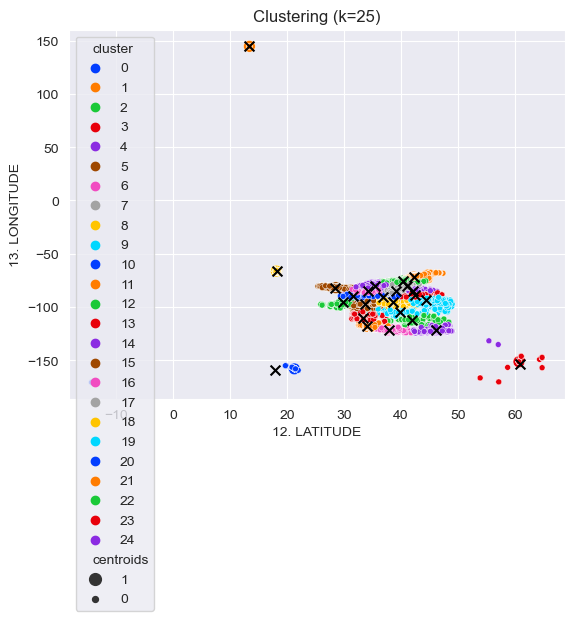

In [70]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x = '12. LATITUDE', 
                y = '13. LONGITUDE', 
                data = plant_locations_unique, 
                palette = sns.color_palette("bright",k),
                hue = 'cluster', 
                size = "centroids", 
                size_order = [1,0],
                legend = "brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s = 50, c = 'black', marker="x")

## Import all categorized CDI Data

In [71]:
cdi_datasets = pd.read_pickle('processed_data/cdi_datasets.pkl')
cdi_datasets = cdi_datasets.reset_index()
cdi_datasets

,Year,LocationAbbr,Centroid,Topic
0,2013,AK,"{""type"":""Point"", ""coordinates"":[-148.716968,61...","[Alcohol, Cancer, Cardiovascular Disease]"
1,2013,AL,"{""type"":""Point"", ""coordinates"":[-86.766233,33....","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
2,2013,AR,"{""type"":""Point"", ""coordinates"":[-92.576816,35....","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
3,2013,AZ,"{""type"":""Point"", ""coordinates"":[-111.828711,33...","[Alcohol, Cancer, Cardiovascular Disease, Chro..."
4,2013,CA,"{""type"":""Point"", ""coordinates"":[-119.355165,35...","[Alcohol, Cancer, Cardiovascular Disease, Diab..."
...,...,...,...,...
250,2017,VT,"{""type"":""Point"", ""coordinates"":[-72.814309,44....","[Alcohol, Asthma]"
251,2017,WA,"{""type"":""Point"", ""coordinates"":[-121.624501,47...","[Alcohol, Arthritis, Asthma, Chronic Kidney Di..."
252,2017,WI,"{""type"":""Point"", ""coordinates"":[-89.001006,43....","[Alcohol, Asthma]"
253,2017,WV,"{""type"":""Point"", ""coordinates"":[-80.820221,38....","[Alcohol, Arthritis, Asthma, Cardiovascular Di..."


## Use K-Nearest Neighbors to assign each state population center with a cluster

In [72]:
centers = []
for row in model.cluster_centers_:
    centers.append([row[0], row[1]])
tree = spatial.KDTree(centers)

In [73]:
coord_string = r'{"type":"Point", "coordinates":\[(-?\d+\.\d+),(-?\d+\.\d+)\]}'
p = re.compile(coord_string)
mo = p.search('{"type":"Point", "coordinates":[-148.716968,61.288254]}')

In [74]:
cdi_datasets

,Year,LocationAbbr,Centroid,Topic
0,2013,AK,"{""type"":""Point"", ""coordinates"":[-148.716968,61...","[Alcohol, Cancer, Cardiovascular Disease]"
1,2013,AL,"{""type"":""Point"", ""coordinates"":[-86.766233,33....","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
2,2013,AR,"{""type"":""Point"", ""coordinates"":[-92.576816,35....","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
3,2013,AZ,"{""type"":""Point"", ""coordinates"":[-111.828711,33...","[Alcohol, Cancer, Cardiovascular Disease, Chro..."
4,2013,CA,"{""type"":""Point"", ""coordinates"":[-119.355165,35...","[Alcohol, Cancer, Cardiovascular Disease, Diab..."
...,...,...,...,...
250,2017,VT,"{""type"":""Point"", ""coordinates"":[-72.814309,44....","[Alcohol, Asthma]"
251,2017,WA,"{""type"":""Point"", ""coordinates"":[-121.624501,47...","[Alcohol, Arthritis, Asthma, Chronic Kidney Di..."
252,2017,WI,"{""type"":""Point"", ""coordinates"":[-89.001006,43....","[Alcohol, Asthma]"
253,2017,WV,"{""type"":""Point"", ""coordinates"":[-80.820221,38....","[Alcohol, Arthritis, Asthma, Cardiovascular Di..."


In [75]:
coord = []
for values in cdi_datasets['Centroid']:
    mo = p.search(values)
    coord.append([float(mo[2]), float(mo[1])])
cdi_datasets['Centroid'] = coord
cdi_datasets

,Year,LocationAbbr,Centroid,Topic
0,2013,AK,"[61.288254, -148.716968]","[Alcohol, Cancer, Cardiovascular Disease]"
1,2013,AL,"[33.001471, -86.766233]","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
2,2013,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
3,2013,AZ,"[33.373506, -111.828711]","[Alcohol, Cancer, Cardiovascular Disease, Chro..."
4,2013,CA,"[35.458606, -119.355165]","[Alcohol, Cancer, Cardiovascular Disease, Diab..."
...,...,...,...,...
250,2017,VT,"[44.081127, -72.814309]","[Alcohol, Asthma]"
251,2017,WA,"[47.341728, -121.624501]","[Alcohol, Arthritis, Asthma, Chronic Kidney Di..."
252,2017,WI,"[43.728544, -89.001006]","[Alcohol, Asthma]"
253,2017,WV,"[38.767195, -80.820221]","[Alcohol, Arthritis, Asthma, Cardiovascular Di..."


In [76]:
nearest_centroid = []
for values in cdi_datasets['Centroid']:
    dd, ii = tree.query(values, k=1)
    nearest_centroid.append(ii)
cdi_datasets['Cluster'] = nearest_centroid

Once each state's population center has been assigned a cluster from the plants, we join each plant with the table to create associations

In [77]:
epa_tri = epa_tri.reset_index()
tri_chemicals = epa_tri[[
    '2. TRIFD',
    '34. CHEMICAL'
]]
tri_chemicals = tri_chemicals.merge(plant_locations_unique, on='2. TRIFD')
tri_chemicals

,2. TRIFD,34. CHEMICAL,1. YEAR,4. FACILITY NAME,8. ST,12. LATITUDE,13. LONGITUDE,cluster,centroids
0,07008STFLXMIDDL,n-Butyl alcohol,1993,STAFLEX PRODS,NJ,40.564583,-74.224278,2,0
1,07008STFLXMIDDL,n-Butyl alcohol,1994,STAFLEX PRODS,NJ,40.564583,-74.224278,2,0
2,07008STFLXMIDDL,n-Butyl alcohol,1995,STAFLEX PRODS,NJ,40.564583,-74.224278,2,0
3,07008STFLXMIDDL,n-Butyl alcohol,1996,STAFLEX PRODS,NJ,40.564583,-74.224278,2,0
4,07008STFLXMIDDL,n-Butyl alcohol,1997,STAFLEX PRODS,NJ,40.564583,-74.224278,2,0
...,...,...,...,...,...,...,...,...,...
1824642,60123NVRSL1975F,Methyl ethyl ketone,1997,UNIVERSAL CHEMICALS & COATINGS INC,IL,42.073440,-88.323880,3,0
1824643,97015WRNND12900,Di(2-ethylhexyl) phthalate,1997,WARN INDUSTRIES INC,OR,45.398111,-122.532315,4,0
1824644,24151FLTWD90WEA,Diisocyanates,1997,FLEETWOOD HOMES OF VIRGINIA INC 19-2,VA,37.012280,-79.886420,14,0
1824645,70037KNCLN2805E,Diisocyanates,1997,KENCOIL INC,LA,29.837590,-90.047920,20,0


Produce list of all chemicals produced in each cluster

In [78]:
tri_chemicals = tri_chemicals.groupby(by='cluster')['34. CHEMICAL'].apply(list).reset_index()
tri_chemicals

,cluster,34. CHEMICAL
0,0,"[Xylene (mixed isomers), Xylene (mixed isomers..."
1,1,[Hydrochloric acid (acid aerosols including mi...
2,2,"[n-Butyl alcohol, n-Butyl alcohol, n-Butyl alc..."
3,3,"[Phosphorus (yellow or white), Phosphorus (yel..."
4,4,"[Ethylene glycol, Ethylene glycol, Ethylene gl..."
5,5,"[Ammonia, Ammonia, Ammonia, Ammonia, Ammonia, ..."
6,6,"[Sulfuric acid (acid aerosols including mists,..."
7,7,"[Methyl ethyl ketone, Methyl ethyl ketone, Met..."
8,8,"[1,1,1-Trichloroethane, 1,1,1-Trichloroethane,..."
9,9,"[Sulfuric acid (acid aerosols including mists,..."


In [79]:
freq = []
for l in tri_chemicals['34. CHEMICAL']:
    c = Counter(l)
    top_10 = [x[0] for x in c.most_common(20)]
    freq.append(top_10)
tri_chemicals['34. CHEMICAL'] = freq

In [80]:
cdi_datasets

,Year,LocationAbbr,Centroid,Topic,Cluster
0,2013,AK,"[61.288254, -148.716968]","[Alcohol, Cancer, Cardiovascular Disease]",23
1,2013,AL,"[33.001471, -86.766233]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",6
2,2013,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0
3,2013,AZ,"[33.373506, -111.828711]","[Alcohol, Cancer, Cardiovascular Disease, Chro...",13
4,2013,CA,"[35.458606, -119.355165]","[Alcohol, Cancer, Cardiovascular Disease, Diab...",1
...,...,...,...,...,...
250,2017,VT,"[44.081127, -72.814309]","[Alcohol, Asthma]",21
251,2017,WA,"[47.341728, -121.624501]","[Alcohol, Arthritis, Asthma, Chronic Kidney Di...",4
252,2017,WI,"[43.728544, -89.001006]","[Alcohol, Asthma]",3
253,2017,WV,"[38.767195, -80.820221]","[Alcohol, Arthritis, Asthma, Cardiovascular Di...",7


In [81]:
tri_chemicals = tri_chemicals.merge(cdi_datasets, left_on='cluster', right_on='Cluster')

In [82]:
tri_chemicals['Pattern'] = tri_chemicals['34. CHEMICAL'] + tri_chemicals['Topic']
tri_chemicals

,cluster,34. CHEMICAL,Year,LocationAbbr,Centroid,Topic,Cluster,Pattern
0,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
1,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,MO,"[38.437715, -92.15377]","[Alcohol, Arthritis, Asthma, Cancer, Cardiovas...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
2,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2014,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Cancer, Chronic Kidney Di...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
3,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2014,MO,"[38.437715, -92.15377]","[Alcohol, Arthritis, Asthma, Cancer, Chronic O...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
4,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2015,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Asthma, Cancer, Cardiovas...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
...,...,...,...,...,...,...,...,...
250,24,"[Toluene, Xylene (mixed isomers), Copper, Zinc...",2013,MI,"[42.866412, -84.170753]","[Alcohol, Asthma, Cancer, Cardiovascular Disea...",24,"[Toluene, Xylene (mixed isomers), Copper, Zinc..."
251,24,"[Toluene, Xylene (mixed isomers), Copper, Zinc...",2014,MI,"[42.866412, -84.170753]","[Alcohol, Asthma, Cancer, Chronic Kidney Disea...",24,"[Toluene, Xylene (mixed isomers), Copper, Zinc..."
252,24,"[Toluene, Xylene (mixed isomers), Copper, Zinc...",2015,MI,"[42.866412, -84.170753]","[Alcohol, Asthma, Cancer, Cardiovascular Disea...",24,"[Toluene, Xylene (mixed isomers), Copper, Zinc..."
253,24,"[Toluene, Xylene (mixed isomers), Copper, Zinc...",2016,MI,"[42.866412, -84.170753]","[Alcohol, Asthma, Chronic Kidney Disease, Chro...",24,"[Toluene, Xylene (mixed isomers), Copper, Zinc..."


In [83]:
tri_chemicals['Pattern'] = tri_chemicals['Pattern'].apply(lambda x: list(set(x)))
tri_chemicals

,cluster,34. CHEMICAL,Year,LocationAbbr,Centroid,Topic,Cluster,Pattern
0,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0,"[n-Butyl alcohol, Chromium compounds (except f..."
1,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,MO,"[38.437715, -92.15377]","[Alcohol, Arthritis, Asthma, Cancer, Cardiovas...",0,"[n-Butyl alcohol, Chromium compounds (except f..."
2,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2014,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Cancer, Chronic Kidney Di...",0,"[n-Butyl alcohol, Chromium compounds (except f..."
3,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2014,MO,"[38.437715, -92.15377]","[Alcohol, Arthritis, Asthma, Cancer, Chronic O...",0,"[n-Butyl alcohol, Chromium compounds (except f..."
4,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2015,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Asthma, Cancer, Cardiovas...",0,"[n-Butyl alcohol, Chromium compounds (except f..."
...,...,...,...,...,...,...,...,...
250,24,"[Toluene, Xylene (mixed isomers), Copper, Zinc...",2013,MI,"[42.866412, -84.170753]","[Alcohol, Asthma, Cancer, Cardiovascular Disea...",24,"[Nickel compounds, Chromium compounds (except ..."
251,24,"[Toluene, Xylene (mixed isomers), Copper, Zinc...",2014,MI,"[42.866412, -84.170753]","[Alcohol, Asthma, Cancer, Chronic Kidney Disea...",24,"[Nickel compounds, Chromium compounds (except ..."
252,24,"[Toluene, Xylene (mixed isomers), Copper, Zinc...",2015,MI,"[42.866412, -84.170753]","[Alcohol, Asthma, Cancer, Cardiovascular Disea...",24,"[Nickel compounds, Chromium compounds (except ..."
253,24,"[Toluene, Xylene (mixed isomers), Copper, Zinc...",2016,MI,"[42.866412, -84.170753]","[Alcohol, Asthma, Chronic Kidney Disease, Chro...",24,"[Nickel compounds, Chromium compounds (except ..."


In [84]:
tri_chemicals = tri_chemicals.groupby('cluster')['Pattern'].sum()
tri_chemicals.apply(lambda x: list(set(x)))
tri_chemicals

cluster
0     [n-Butyl alcohol, Chromium compounds (except f...
1     [Chromium compounds (except for chromite ore m...
2     [n-Butyl alcohol, Chromium compounds (except f...
3     [Chromium compounds (except for chromite ore m...
4     [Chromium compounds (except for chromite ore m...
5     [Chromium compounds (except for chromite ore m...
6     [Chromium compounds (except for chromite ore m...
7     [Nickel compounds, Chromium compounds (except ...
9     [Sulfuric acid (acid aerosols including mists,...
10    [o-Xylene, n-Butyl alcohol, Chromium compounds...
12    [Chromium compounds (except for chromite ore m...
13    [Chromium compounds (except for chromite ore m...
14    [n-Butyl alcohol, Chromium compounds (except f...
15    [Chromium compounds (except for chromite ore m...
17    [n-Butyl alcohol, Chromium compounds (except f...
18    [Chromium compounds (except for chromite ore m...
19    [Chromium compounds (except for chromite ore m...
20    [n-Butyl alcohol, Chromium compoun

## Mine the patterns

In [85]:
data = tri_chemicals.to_list()

In [86]:
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df.to_csv('processed_data/fpgrowth.csv', index=False)

In [88]:
patterns = fpgrowth(df, min_support=0.6, use_colnames=True)

In [91]:
patterns[patterns['itemsets'].map(len) > 1]

,support,itemsets
28,1.000000,"(Alcohol, Toluene)"
29,1.000000,"(Sulfuric acid (acid aerosols including mists,..."
30,1.000000,"(Alcohol, Sulfuric acid (acid aerosols includi..."
31,1.000000,"(Toluene, Alcohol, Sulfuric acid (acid aerosol..."
32,1.000000,"(Ammonia, Sulfuric acid (acid aerosols includi..."
...,...,...
1072634,0.636364,"(Alcohol, Phosphoric acid, Toluene, Certain gl..."
1072635,0.636364,"(Ammonia, Alcohol, Phosphoric acid, Toluene, C..."
1072636,0.636364,"(Ammonia, Alcohol, Phosphoric acid, Certain gl..."
1072637,0.636364,"(Ammonia, Phosphoric acid, Toluene, Certain gl..."


In [98]:
health_topics = set()
for l in cdi_datasets['Topic']:
    health_topics |= set(l)

In [101]:
for s in patterns['itemsets']:
    print(s.intersection(health_topics))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




frozenset({'Cardiovascular Disease', 'Arthritis', 'Chronic Kidney Disease'})
frozenset({'Cardiovascular Disease', 'Arthritis', 'Chronic Kidney Disease'})
frozenset({'Arthritis', 'Chronic Kidney Disease'})
frozenset({'Arthritis', 'Chronic Kidney Disease'})
frozenset({'Arthritis', 'Chronic Kidney Disease'})
frozenset({'Arthritis', 'Chronic Kidney Disease'})
frozenset({'Arthritis', 'Chronic Kidney Disease'})
frozenset({'Arthritis', 'Chronic Kidney Disease'})
frozenset({'Cardiovascular Disease', 'Arthritis', 'Chronic Kidney Disease', 'Cancer'})
frozenset({'Cardiovascular Disease', 'Arthritis', 'Chronic Kidney Disease', 'Cancer'})
frozenset({'Cardiovascular Disease', 'Arthritis', 'Chronic Kidney Disease', 'Cancer'})
frozenset({'Cardiovascular Disease', 'Arthritis', 'Chronic Kidney Disease', 'Cancer'})
frozenset({'Cardiovascular Disease', 'Arthritis', 'Chronic Kidney Disease', 'Cancer'})
frozenset({'Cardiovascular Disease', 'Arthritis', 'Chronic Kidney Disease', 'Cancer'})
frozenset({'Cardi

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Cancer', 'Alcohol', 'Diabetes'})
frozenset({'Cardiovascular Disease', 'Alcohol'})
frozenset({'Cardiovascular Disease', 'Alcohol'})
frozenset({'Cardiovascular Disease', 'Alcohol', 'Diabetes'})
frozenset({'Cardiovascular Disease', 'Alcohol'})
frozenset({'Cardiovascular Disease', 'Alcohol', 'Diabetes'})
frozenset({'Cardiovascular Disease', 'Alcohol', 'Diabetes'})
frozenset({'Cardiovascular Disease', 'Alcohol'})
frozenset({'Cardiovascular Disease', 'Alcohol', 'Diabetes'})
frozenset(

In [103]:
patterns[patterns['itemsets'].apply(lambda x: bool(x & health_topics) and len(x) > 1)]

,support,itemsets
28,1.000000,"(Alcohol, Toluene)"
30,1.000000,"(Alcohol, Sulfuric acid (acid aerosols includi..."
31,1.000000,"(Toluene, Alcohol, Sulfuric acid (acid aerosol..."
34,1.000000,"(Ammonia, Alcohol)"
36,1.000000,"(Alcohol, Ammonia, Sulfuric acid (acid aerosol..."
...,...,...
1072634,0.636364,"(Alcohol, Phosphoric acid, Toluene, Certain gl..."
1072635,0.636364,"(Ammonia, Alcohol, Phosphoric acid, Toluene, C..."
1072636,0.636364,"(Ammonia, Alcohol, Phosphoric acid, Certain gl..."
1072637,0.636364,"(Ammonia, Phosphoric acid, Toluene, Certain gl..."
